
# Headers



In [1]:
%matplotlib inline
import cobra
import PyDSTool as dst
import pandas as pd
import matplotlib.pyplot as plt
import copy
import sys
import pdb
import time


# Utility Functions



In [33]:
# Functions for initialization

def cleanupname(name):
    """
     The reaction names in the model files 
     don't have brackets or parentheses. I replaced
     those found in the mediaFluxes file.
     """
    name = name.replace('[', '__40__')#_LPAREN_')
    name = name.replace(']', '__41__')#'_RPAREN_')
    name = name.replace('(', '__40__')#'_LPAREN_')
    name = name.replace(')', '__41__')#'_RPAREN_')
    return name

def defineDFBAModel(SpeciesDict , MediaDF):
    print("Defining Dynamical model... \n")
    ParDef = dict()
    VarDef = dict()
    ICS = dict()
    exchange_list = []
    mediaDerivedComponents = {}
    for i, row in MediaDF.iterrows():
        N = cleanupname(row.Reaction)
        mediaDerivedComponents[N] = row['Flux Value'] / (24.0*60.0) # Per minute

    for species in SpeciesDict.keys():
        SpeciesDict[species]['SpeciesModel'] = cobra.io.read_sbml_model(SpeciesDict[species]['File'])
        SpeciesDict[species]['OriginalLB'] = {r.id:r.lower_bound/10 for r in SpeciesDict[species]['SpeciesModel'].exchanges}
        SpeciesDict[species]['solution'] = SpeciesDict[species]['SpeciesModel'].optimize()
        SpeciesDict[species]['Name'] = SpeciesDict[species]['SpeciesModel'].name.split(' ')[0]
        exchange_list += SpeciesDict[species]['SpeciesModel'].exchanges
        Name=SpeciesDict[species]['Name']
        ParDef['mu' + '_' + Name] = SpeciesDict[species]['solution'].objective_value/60
        VarDef[Name] =  'mu_' + Name + ' * ' + Name + '- ' +'Dilution * ' + Name ### Biomass
        ICS[Name] = SpeciesDict[species]['initAbundance']
    ParDef['Dilution'] = 0.002
    all_exchanges = set()

    for ex in exchange_list:
        all_exchanges.add(ex.id)
        #     all_exchanges = list(set(exchange_list))

    for rid in all_exchanges:
        VarDef[rid] =  '-Dilution * ' + rid
        ICS[rid] = 0.1

        if rid in mediaDerivedComponents.keys():
            ParDef[rid + '_influx'] = mediaDerivedComponents[rid]
            VarDef[rid] += ' + ' +  rid + '_influx'

        for species in SpeciesDict.keys():
            # print(SpeciesDict[species]['Name'])
            if 'h2o' in rid:
                print(species, rid)
            if rid in [species_r.id for species_r in SpeciesDict[species]['SpeciesModel'].exchanges]:
                Name = SpeciesDict[species]['Name']
                ParDef[rid + '_' + Name] = SpeciesDict[species]['solution'].fluxes[rid]/60.0
                VarDef[rid] += ' + ' +  rid + '_' + Name + ' * ' + Name

    ModelDef = dst.args(name='Community',
                    pars=ParDef,
                        varspecs=VarDef,
                        ics=ICS)
    ModelDS = dst.Vode_ODEsystem(ModelDef)
    print("Done!")
    return (SpeciesDict, ModelDef, ModelDS)

# Functions for model updates

def recomputeLowerBounds(SpeciesDict, PrevSteadyState, Kmax):
    for species in SpeciesDict.keys():
        for rid in [rxn.id for rxn in SpeciesDict[species]['SpeciesModel'].exchanges]:
            SpeciesDict[species]['SpeciesModel'].reactions.get_by_id(rid) \
                                                   .lower_bound = \
                                                    SpeciesDict[species]['OriginalLB'][rid] \
                                                    * PrevSteadyState[rid]/(Kmax+PrevSteadyState[rid])
#             if 'gln_L' in rid:
#                 print(species, ' gln_L LB:', SpeciesDict[species]['SpeciesModel'].reactions.get_by_id(rid).lower_bound)
    return SpeciesDict

def updateFluxParameters(SpeciesDict, ModelDS, PrevSteadyState, debug):
    ParDef = {}
    ICS = {}
    for species in SpeciesDict:
        solution = SpeciesDict[species]['SpeciesModel'].optimize()
        #print(solution.fluxes['EX_gln_L__40__e__41__']/60.0)
        Name = SpeciesDict[species]['Name']
        ParDef['mu_' + Name] = solution.objective_value/60.0
        ICS[Name] = PrevSteadyState[Name]
        exchanges = [r.id for r in SpeciesDict[species]['SpeciesModel'].exchanges]
        for rid in exchanges:
            if abs(solution.fluxes[rid]/60.0) < 1e-14: # Because very small non-zero solutions may come up despite 0 LB
                solution.fluxes[rid] = 0
            ParDef[rid + '_' + Name] = solution.fluxes[rid]/60.0
    for variable in 
        ICS[rid] = PrevSteadyState[rid]
#             if 'gln_L' in rid:
#                 print(Name, '=', species, ' ParDef of gln_L =', ParDef[rid + '_' + Name])
#                 print(species, ' gln_L LB:', SpeciesDict[species]['SpeciesModel'].reactions.get_by_id(rid).lower_bound)
    ModelDS.set(pars=ParDef, ics=ICS)
    return ModelDS

def update(SpeciesDict, ModelDS, PrevSteadyState, Kmax,debug=False):
    UpdatedSpeciesDict = recomputeLowerBounds(SpeciesDict,
                                              PrevSteadyState, Kmax)
    
    UpdatedDynamicModel = updateFluxParameters(UpdatedSpeciesDict,
                                               ModelDS,
                                               PrevSteadyState,debug)
    # P = simulateModel(updatedDynamicalModel)
    return(UpdatedSpeciesDict, UpdatedDynamicModel)

def get_ss(PointSet):
    SSPoints={}
    for k in PointSet.keys():
        SSPoints[k]=PointSet[k][-1]
    return(SSPoints)

def checkNegativeMetabolites(PointSet,StoreNegatives):
    IndexStop = len(PointSet['t'])

    for variable in PointSet.keys():
        if any(PointSet[variable] < 0.0): # checking only final Tpoint, b/c monotonic
            varIndex = next((index for index,value in enumerate(list(PointSet[variable])) if value < 0.0), None)
            #varIndex= PointSet.index(filter(lambda x: x<0, PointSet)[0])
            if varIndex < IndexStop:
                # Update the index for the first negative crossing
                IndexStop = varIndex
               # print(IndexStop)

    if IndexStop < len(PointSet['t']) and IndexStop > 0:
        P_tilFirstNeg={}
        if len(P[variable] > IndexStop+5):
            Extension =5
        elif len(P[variable] > IndexStop+2):
            Extension =2
        else:
            Extension = 0
        for variable in PointSet.keys():
            P_tilFirstNeg[variable]=P[variable][:IndexStop] 
            if P[variable][IndexStop+Extension] < 0.0:
                P_tilFirstNeg[variable][IndexStop-1] = 0.0
                print('P_tillFirstNeg = ', P_tilFirstNeg[variable])
                StoreNegatives.add(variable)
                print(variable, 'is 0 at ', P['t'][IndexStop])
                
        P_tilFirstNeg['t'] = PointSet['t'][:IndexStop]
        PointSet = P_tilFirstNeg
    return(PointSet,StoreNegatives)


# Test:



In [34]:
SpeciesDict = {'Sp1': {'File': './data/average-european-diet/Bacteroides_sp_1_1_14.xml', 'initAbundance': 0.01},
 'Sp10': {'File': './data/average-european-diet/Desulfovibrio_piger_ATCC_29098.xml',
  'initAbundance': 0.01},
 'Sp2': {'File': './data/average-european-diet/Ruminococcus_flavefaciens_FD_1.xml',
  'initAbundance': 0.01},
 'Sp3': {'File': './data/average-european-diet/Lactobacillus_brevis_ATCC_367.xml',
  'initAbundance': 0.01},
 'Sp4': {'File': './data/average-european-diet/Mycobacterium_avium_subsp_avium_ATCC_25291.xml',
  'initAbundance': 0.01},
 'Sp5': {'File': './data/average-european-diet/Actinomyces_viscosus_C505.xml',
  'initAbundance': 0.01},
 'Sp6': {'File': './data/average-european-diet/Exiguobacterium_aurantiacum_DSM_6208.xml',
  'initAbundance': 0.01},
 'Sp7': {'File': './data/average-european-diet/Arcanobacterium_haemolyticum_DSM_20595.xml',
  'initAbundance': 0.01},
 'Sp8': {'File': './data/average-european-diet/Streptococcus_intermedius_JTH08.xml',
  'initAbundance': 0.01},
 'Sp9': {'File': './data/average-european-diet/Bifidobacterium_longum_infantis_ATCC_15697.xml',
  'initAbundance': 0.01}}

# SpeciesDict = {'Sp1': {'File':'./data/Bacteroides_sp_1_1_14.xml',
#                       'initAbundance':2e-3},
#                 'Sp2': {'File':'./data/Actinomyces_viscosus_C505.xml',
#                         'initAbundance':2e-3},
#                'Sp3': {'File':'./data/Bifidobacterium_longum_infantis_ATCC_15697.xml',
#                       'initAbundance':2e-3},
#                'Sp4': {'File':'./data/Desulfovibrio_piger_ATCC_29098.xml',
#                       'initAbundance':2e-3},
# }

MediaDF = pd.read_csv('./data/diet-definitions/VMH_HighFiber.tsv', sep='\t')


In [43]:
SpeciesDict, Definition, ModelDS = defineDFBAModel(SpeciesDict, MediaDF)
InitialValues = {k:[v] for (k,v) in Definition.ics.items()}
AllPoints = []
StoreNegatives = set()
P = InitialValues
T0=0
TEND = 2000
TSPAN = 60
Kmax=0.01
i=0
MaxIter= 1000
TERMINATE = False
starttime = time.clock()
# PrevT0=0
while T0 < TEND and i < MaxIter:
#and not TERMINATE:
    i+=1
    print('--------------------------------------------------------------')
    print('T0 = ' , T0, ' ; Iteration =', i)
   # print(P['EX_gln_L__40__e__41__'][-1])
    SpeciesDict, ModelDS = update(SpeciesDict, ModelDS, get_ss(P), Kmax)

    if T0+TSPAN > TEND:
        TSPAN = TEND - T0

    ModelDS.set(tdata=[T0, T0 + TSPAN])
    P = ModelDS.compute('test').sample() 
#     OldT = P['t'][-1]
#     # Initialize
    P, StoreNegatives = checkNegativeMetabolites(P,StoreNegatives) 
    T0 = P['t'][-1]
    AllPoints.append(P)
    
#     for param in ModelDS.pars.keys():
#         if 'cgly' in param:
#             print(param, ' = ', ModelDS.pars[param])

endtime = time.clock()
print('time of simulation = ' + str(endtime-starttime))


Defining Dynamical model... 

Sp6 EX_h2o__40__e__41__
Sp10 EX_h2o__40__e__41__
Sp4 EX_h2o__40__e__41__
Sp8 EX_h2o__40__e__41__
Sp2 EX_h2o__40__e__41__
Sp3 EX_h2o__40__e__41__
Sp7 EX_h2o__40__e__41__
Sp9 EX_h2o__40__e__41__
Sp1 EX_h2o__40__e__41__
Sp5 EX_h2o__40__e__41__
Done!
--------------------------------------------------------------
T0 =  0  ; Iteration = 1
P_tillFirstNeg =  [1.00000000e-01 9.99765390e-02 9.99530779e-02 ... 6.79231601e-05
 4.41537673e-05 0.00000000e+00]
EX_asn_L__40__e__41__ is 0 at  42.39706617769628
--------------------------------------------------------------
T0 =  42.38706451075179  ; Iteration = 2
P_tillFirstNeg =  [4.62983392e-02 4.62862686e-02 4.62741978e-02 ... 2.97823273e-05
 1.70667961e-05 0.00000000e+00]
EX_gln_L__40__e__41__ is 0 at  79.80330055009168
--------------------------------------------------------------
T0 =  79.7932988831472  ; Iteration = 3
--------------------------------------------------------------
T0 =  139.7932988831472  ; Iteration 

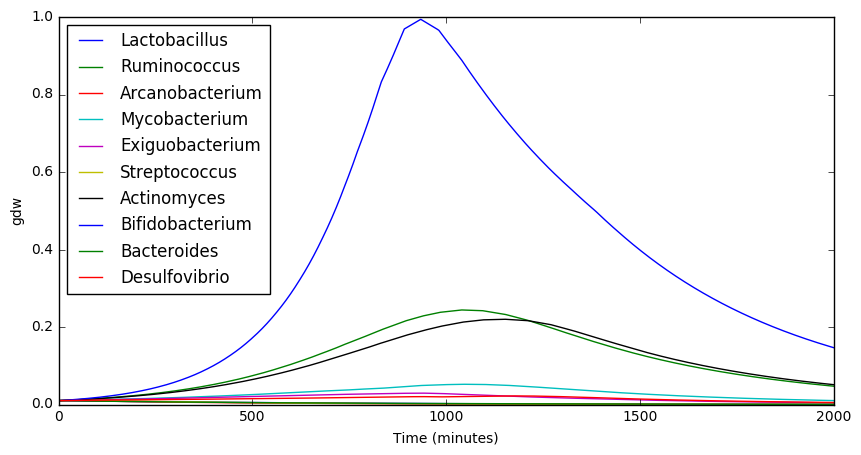

In [44]:
TimePoints={}
TimePoints['t'] =[]
plt.figure(figsize=(10,5))
for P in AllPoints:
    TimePoints['t'] += list(P['t'])
    
for sp in SpeciesDict.keys():
    TimePoints[SpeciesDict[sp]['Name']] = []
    for P in AllPoints:
        TimePoints[SpeciesDict[sp]['Name']]+=list(P[SpeciesDict[sp]['Name']])

for k in TimePoints.keys():
    if k!= 't':
        plt.plot(TimePoints['t'], TimePoints[k], label=k)
        plt.xlabel('Time (minutes)')
        plt.ylabel('gdw')
plt.xlabel('Time (minutes)')
plt.ylabel('gdw')
plt.legend(loc=2)

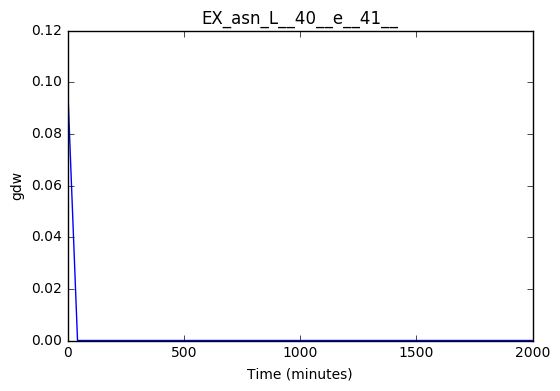

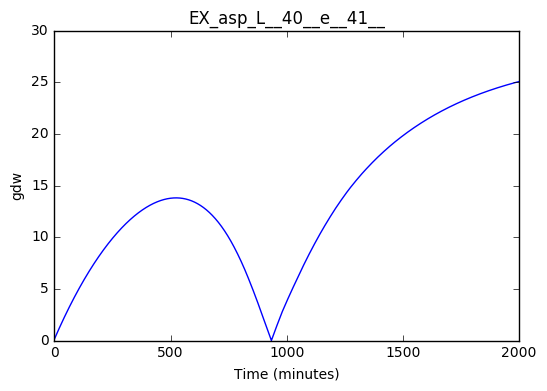

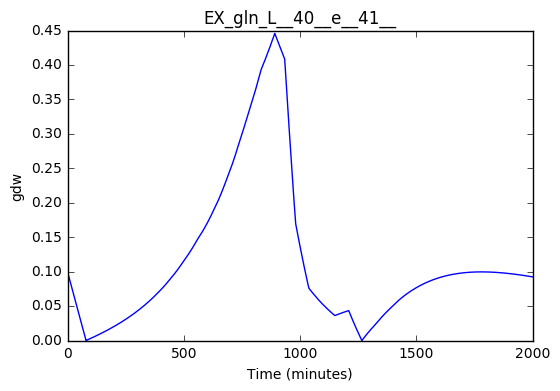

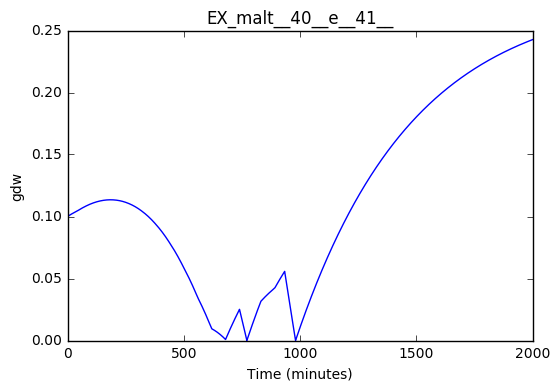

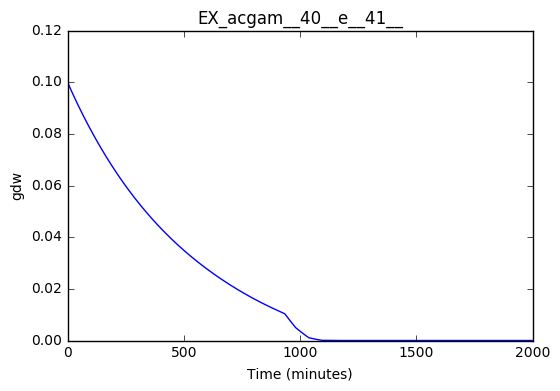

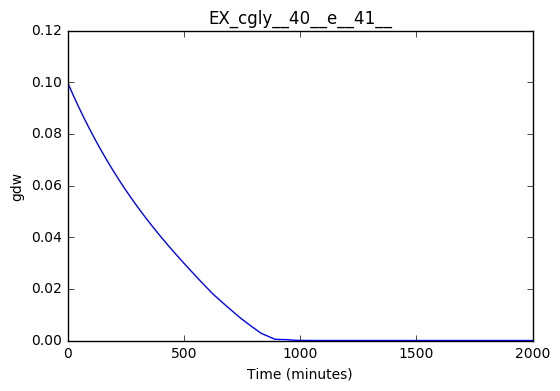

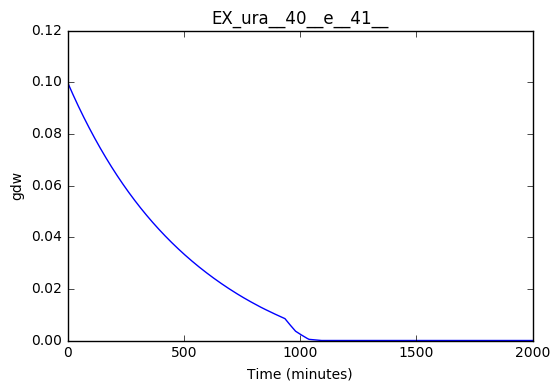

In [45]:
TimePoints={}
TimePoints['t'] =[]

for P in AllPoints:
    TimePoints['t'] += list(P['t'])
    
for variable in StoreNegatives:
    TimePoints[variable] = []
    for P in AllPoints:
        TimePoints[variable]+=list(P[variable])

for k in TimePoints.keys():
    if k != 't':
        plt.figure()
        plt.plot(TimePoints['t'], TimePoints[k])
    else:
        continue
    plt.title(k)    
    plt.xlabel('Time (minutes)')
    #plt.ylim([0,0.5])
    plt.ylabel('gdw')

In [39]:
for i in range(0,len(AllPoints)):
    if any(AllPoints[i]['EX_gly__40__e__41__'] < 0):
        print(i)
        print (AllPoints[i]['t'])
        print(AllPoints[i]['EX_gly__40__e__41__'])


In [40]:
[v for v in AllPoints[228]['EX_gly__40__e__41__']]

IndexError: list index out of range

In [42]:
AllPoints[-1]

Pointset <no name> (parameterized)
Independent variable:
t:  [1332.00200033 1332.012002  , ..., 1391.99199867 1392.00200033]
Coordinates:
Actinomyces:  [0.19092594 0.19092226, ..., 0.1701224  0.17011913]
Arcanobacterium:  [0.0007691  0.00076909, ..., 0.00068215 0.00068213]
Bacteroides:  [0.00152189 0.00152186, ..., 0.00135229 0.00135227]
Bifidobacterium:  [0.54844971 0.54843891, ..., 0.48733148 0.48732188]
DM_2HYMEPH:  [0.00696687 0.00696673, ..., 0.00617918 0.00617906]
DM_4HBA:  [0.00708372 0.00708357, ..., 0.0062833  0.00628317]
DM_5DRIB:  [0.00912302 0.00912284, ..., 0.00809156 0.0080914 ]
DM_5MTR:  [0.00937518 0.009375  , ..., 0.00832057 0.0083204 ]
DM_GCALD:  [0.00708372 0.00708357, ..., 0.0062833  0.00628317]
DM_clpn140__40__c__41__:  [0.00696687 0.00696673, ..., 0.00617918 0.00617906]
DM_clpn160__40__c__41__:  [0.00696687 0.00696673, ..., 0.00617918 0.00617906]
DM_clpn180__40__c__41__:  [0.00696687 0.00696673, ..., 0.00617918 0.00617906]
DM_clpni16__40__c__41__:  [0.00696687 0.0

In [46]:
for k in ModelDS.pars.keys():
    if 'mu' in k:
        print(k, '=', ModelDS.pars[k])

mu_Actinomyces = 3.1347763171040654e-09
mu_Exiguobacterium = 1.222569475862722e-09
mu_Mycobacterium = 1.2225694756635807e-09
mu_Arcanobacterium = -5.604769646835279e-19
mu_Bifidobacterium = 1.2429680731675647e-09
mu_Bacteroides = 1.2429680725831632e-09
mu_Streptococcus = 0.0
mu_Lactobacillus = 1.24296807181411e-09
mu_Desulfovibrio = 1.2429680637128103e-09
mu_Ruminococcus = 1.2225694756635807e-09


In [31]:
ModelDS.pars

dict_keys(['EX_cd2__40__e__41___Ruminococcus', 'EX_ribflv__40__e__41___Streptococcus', 'EX_glyc3p__40__e__41___Arcanobacterium', 'EX_pi__40__e__41___influx', 'EX_q8__40__e__41___Mycobacterium', 'EX_alaleu__40__e__41___Streptococcus', 'EX_2obut__40__e__41___Bacteroides', 'EX_pro_L__40__e__41___Bacteroides', 'DM_dhptd__40__c__41___Ruminococcus', 'EX_tyr_L__40__e__41___Exiguobacterium', 'EX_salcn__40__e__41___Ruminococcus', 'EX_metsox_R_L__40__e__41___Actinomyces', 'EX_ac__40__e__41___Mycobacterium', 'EX_gcald__40__e__41___Actinomyces', 'mu_Actinomyces', 'EX_dad_2__40__e__41___Exiguobacterium', 'EX_malttr__40__e__41___Arcanobacterium', 'EX_ser_D__40__e__41___Actinomyces', 'EX_salcn__40__e__41___Actinomyces', 'EX_na1__40__e__41___Desulfovibrio', 'EX_mops__40__e__41___Ruminococcus', 'EX_glu_L__40__e__41___Bacteroides', 'DM_4HBA_Desulfovibrio', 'EX_mnl__40__e__41___Actinomyces', 'EX_his_L__40__e__41___Arcanobacterium', 'DM_thmpp__40__c__41___Lactobacillus', 'EX_alagly__40__e__41___Arcanobact

In [15]:
ModelDS.pars.keys()

dict_keys(['EX_cd2__40__e__41___Ruminococcus', 'EX_ribflv__40__e__41___Streptococcus', 'EX_glyc3p__40__e__41___Arcanobacterium', 'EX_pi__40__e__41___influx', 'EX_q8__40__e__41___Mycobacterium', 'EX_alaleu__40__e__41___Streptococcus', 'EX_2obut__40__e__41___Bacteroides', 'EX_pro_L__40__e__41___Bacteroides', 'DM_dhptd__40__c__41___Ruminococcus', 'EX_tyr_L__40__e__41___Exiguobacterium', 'EX_salcn__40__e__41___Ruminococcus', 'EX_metsox_R_L__40__e__41___Actinomyces', 'EX_ac__40__e__41___Mycobacterium', 'EX_gcald__40__e__41___Actinomyces', 'mu_Actinomyces', 'EX_dad_2__40__e__41___Exiguobacterium', 'EX_malttr__40__e__41___Arcanobacterium', 'EX_ser_D__40__e__41___Actinomyces', 'EX_salcn__40__e__41___Actinomyces', 'EX_na1__40__e__41___Desulfovibrio', 'EX_mops__40__e__41___Ruminococcus', 'EX_glu_L__40__e__41___Bacteroides', 'DM_4HBA_Desulfovibrio', 'EX_mnl__40__e__41___Actinomyces', 'EX_his_L__40__e__41___Arcanobacterium', 'DM_thmpp__40__c__41___Lactobacillus', 'EX_alagly__40__e__41___Arcanobact

# fgghfgh

In [ ]:
for species in SpeciesDict.keys():
    print(SpeciesDict[species]['OriginalLB'])

In [ ]:
for species in SpeciesDict.keys():
    print(SpeciesDict[species]['OriginalLB']['EX_gln_L__40__e__41__'])


In [ ]:
AllPoints